***Andrew Plum***<br/>
***CS 474***<br/>
***11/18/2024***

### HW 5: Build a many-to-one RNN for sentiment analysis

In this homework, you will build a many-to-one RNN for sentiment analysis, i.e., classify reviews into two categories: positive (1) and negative(0).

**Dataset**: 

    -IMDb Movie Reviews for binary sentiment classification
    -A set of 50,000 reviews with labels. All reviews have been cleaned.

In [1]:
#Feel free to import other necassary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm # you may need to install this package
tqdm.pandas()
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

#### 1. Load the dataset
In the my_imdb.csv file, the 'review' column has preprocessed texts of user reviews, and the 'label' has binary catogories. 1 indicates positive comments, and 0 means negative comments.

In [2]:
# read processed data
df = pd.read_csv('my_imdb.csv')
print(df.shape)
df.head()

(50000, 2)


,review,label
0,One reviewer mentioned watching Oz episode hoo...,1
1,A wonderful little production . The filming te...,1
2,I thought wonderful way spend time hot summer ...,1
3,Basically family little boy Jake think zombie ...,0
4,Petter Mattei Love Time Money visually stunnin...,1


#### 2. Text vectorization
Text vectorization converts texts into sequences of numeric values

- The **vocabulary** is a set that contains all unique words in the dataset.
- The **vectorizer** is dictionary that contains every word in the vocabulary set and its index
- The **padding** creates vectors with fixex length, e.g., 256
- Feel free to change the following code to use other text vectorization approaches, e.g., TF-IDF or BoW.

2.1 Create the vocabulary and the vectorizer

In [3]:
# get all words
text = df.review.values
words = ' '.join(text)
words = words.split() 

# build vocabulary
vocab = sorted(Counter(words), key=Counter(words).get, reverse=True)
ID2W = dict(enumerate(vocab, 1))
ID2W[0] = '<PAD>' # special word for paddding purpose, and the index is 0
vectorizer = {word: ID for ID, word in ID2W.items()}
vectorizer

{'.': 1,
 ',': 2,
 'I': 3,
 '-': 4,
 'movie': 5,
 'film': 6,
 'The': 7,
 'one': 8,
 '!': 9,
 'like': 10,
 'It': 11,
 '?': 12,
 'time': 13,
 'This': 14,
 'good': 15,
 'character': 16,
 'story': 17,
 'would': 18,
 'get': 19,
 'make': 20,
 'see': 21,
 'really': 22,
 'even': 23,
 'scene': 24,
 'much': 25,
 'well': 26,
 'people': 27,
 'bad': 28,
 'great': 29,
 'way': 30,
 'show': 31,
 'made': 32,
 'thing': 33,
 'first': 34,
 'also': 35,
 'could': 36,
 'think': 37,
 'life': 38,
 'But': 39,
 'know': 40,
 'go': 41,
 'And': 42,
 'plot': 43,
 'seen': 44,
 'actor': 45,
 'watch': 46,
 'A': 47,
 'say': 48,
 'year': 49,
 'love': 50,
 'many': 51,
 'end': 52,
 'two': 53,
 'acting': 54,
 'look': 55,
 'never': 56,
 'There': 57,
 'In': 58,
 'little': 59,
 'best': 60,
 'ever': 61,
 'better': 62,
 'work': 63,
 'If': 64,
 'take': 65,
 'come': 66,
 'He': 67,
 'find': 68,
 'man': 69,
 'part': 70,
 'still': 71,
 'something': 72,
 'want': 73,
 'give': 74,
 'back': 75,
 'lot': 76,
 'real': 77,
 'performance': 78

2.2 Sample results of vectorization

In [4]:
print('Text sample:', text[0])
num_vec = [vectorizer[w] for w in text[0].split()]
print('Coverted vector:',  len(num_vec), num_vec,)

Text sample: One reviewer mentioned watching Oz episode hooked . They right , exactly happened . The first thing struck Oz brutality unflinching scene violence , set right word GO . Trust , show faint hearted timid . This show pull punch regard drug , sex violence . Its hardcore , classic use word . It called OZ nickname given Oswald Maximum Security State Penitentary . It focus mainly Emerald City , experimental section prison cell glass front face inwards , privacy high agenda . Em City home many . . Aryans , Muslims , gangsta , Latinos , Christians , Italians , Irish . . . . scuffle , death stare , dodgy dealing shady agreement never far away . I would say main appeal show due fact go show dare . Forget pretty picture painted mainstream audience , forget charm , forget romance . . . OZ mess around . The first episode I ever saw struck nasty surreal , I say I ready , I watched , I developed taste Oz , got accustomed high level graphic violence . Not violence , injustice crooked guard

2.3 Apply vectorization to the whole dataset
- Apply padding to create sequences with fixed length
- The final dataset with with numeric features is (X, Y)

In [5]:
# text vectorization and padding
vecs = [[vectorizer[w] for w in r.split()] for r in tqdm(text)] # vecs contains the vectorized reviews of varying length
seq_length = 256
    
X = np.full((len(vecs), seq_length), 0, dtype=int) # create matrix whose shape is (50000, 256) initialized with 0
for i, vec in enumerate(vecs): 
    X[i, :len(vec)] = np.array(vec)[:seq_length] # of each vectorized review, grab only up to the first 256 values and store in the row of X

print('Text vectors:', X.shape)
Y = df.label.to_numpy()
print('Labels:', Y.shape)

100%|███████████████████████████████████████████████████████| 50000/50000 [00:02<00:00, 19992.00it/s]


Text vectors: (50000, 256)
Labels: (50000,)


In [6]:
print('Original vector:\n', vec[0])
print('Results with padding:\n', X[0])

Original vector:
 291
Results with padding:
 [  191  1083   930    81  3724   186  3030     1   118   114     2   527
   500     1     7    34    33  3086  3724  5192 15234    24   490     2
   126   114   259  7473     1  5550     2    31  6620  2169 11285     1
    14    31   923  2106  2177   591     2   289   490     1   677  3805
     2   242   262   259     1    11   342  9227 10121   279 14927 22637
 12715  4100 55917     1    11   758  1332 29362  1094     2  4665  1963
  1105  2317  2079   822   243 55918     2 16586   237  4338     1 18349
  1094   261    51     1     1 25451     2  8327     2 12516     2 15235
     2  5060     2  7897     2  2344     1     1     1     1 22638     2
   251  4076     2  7347  1674  8574  9867    56   144   160     1     3
    18    48   193  1066    31   587    96    41    31  2759     1  4156
   106   281  4057  2373   166     2   798  1179     2   798   740     1
     1     1  9227   793   100     1     7    34   186     3    61   130
  3086

#### 3. Prepare the training, validation and test sets. 15 points
- Use 50% data for training, 20% for validation, and 30% for testing
- Set the batch size to 128

In [7]:
# Split the data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.5, random_state = 0)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_test, Y_test, test_size = 0.6, random_state = 0)

print("Training set:")
print(X_train.shape)
print(Y_train.shape)
print()
print("Validation set:")
print(X_validation.shape)
print(Y_validation.shape)
print()
print("Test set:")
print(X_test.shape)
print(Y_test.shape)
print()

# Use TensorDataset and DataLoader

X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(Y_train)
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

X_validation_tensor = torch.tensor(X_validation)
Y_validation_tensor = torch.tensor(Y_validation)
validation_dataset = TensorDataset(X_validation_tensor, Y_validation_tensor)

X_test_tensor = torch.tensor(X_test)
Y_test_tensor = torch.tensor(Y_test)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle = True)


Training set:
(25000, 256)
(25000,)

Validation set:
(10000, 256)
(10000,)

Test set:
(15000, 256)
(15000,)



#### 4. Build a many-to-one RNN. 40 points
- GRU or LSTM is preferred

In [8]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.linear = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        out, (hidden, cell) = self.lstm(X)
        out = self.linear(out)
        out = self.sigmoid(out)
        
        return out
    
    def train_model(self, train_dataloader, validation_dataloader, num_epochs, loss_kind, optimizer):
        train_loss = []
        validation_loss = []
        
        for epoch in range(num_epochs):
            self.train()
            epoch_train_losses = []
            for inputs, labels in train_dataloader:
                inputs = inputs.float()
                labels = labels.float()
                optimizer.zero_grad()
                outputs = self(inputs).squeeze()
                tr_loss = loss_kind(outputs, labels)
                tr_loss.backward()
                optimizer.step()
                epoch_train_losses.append(tr_loss.item())
            
            self.eval()
            epoch_validation_losses = []
            with torch.no_grad():
                for inputs, labels in validation_dataloader:
                    inputs = inputs.float()
                    labels = labels.float()
                    outputs = self(inputs).squeeze()
                    val_loss = loss_kind(outputs, labels)
                    epoch_validation_losses.append(val_loss.item())
               
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
            avg_validation_loss = sum(epoch_validation_losses) / len(epoch_validation_losses)
            train_loss.append(avg_train_loss)
            validation_loss.append(avg_validation_loss)
            
            print("Epoch: ", epoch + 1)
            print("Training loss: ", tr_loss.item())
            print("Validation loss: ", val_loss.item())
            
        return train_loss, validation_loss
    
    def evaluate(self, dataloader):
        self.eval()
        y_hat = []
        y = []
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs = inputs.float()
                labels = labels.float()
                outputs = self(inputs).squeeze()
                predictions = (outputs > 0.5).float()
                y_hat.extend(predictions.numpy())
                y.extend(labels.numpy())
                
        accuracy = accuracy_score(y, y_hat)
        
        return accuracy, y_hat, y

# hyperparameters
# - batch_size set above in previous cell

input_size = 256
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 500
loss_kind = nn.BCELoss() # binary cross entropy

LSTM_RNN = LSTM_Model(input_size, hidden_size, num_layers, output_size, batch_size)
optimizer = Adam(LSTM_RNN.parameters(), lr = 0.005)
        

#### 5. Train the above model. 30 points

Epoch:  1
Training loss:  0.6865877509117126
Validation loss:  0.6878781914710999
Epoch:  2
Training loss:  0.6954066157341003
Validation loss:  0.693553626537323
Epoch:  3
Training loss:  0.6959971785545349
Validation loss:  0.6900829076766968
Epoch:  4
Training loss:  0.6907013654708862
Validation loss:  0.6936023235321045
Epoch:  5
Training loss:  0.71017986536026
Validation loss:  0.6862073540687561
Epoch:  6
Training loss:  0.6894562840461731
Validation loss:  0.6980143785476685
Epoch:  7
Training loss:  0.694052517414093
Validation loss:  0.6907708048820496
Epoch:  8
Training loss:  0.6958293914794922
Validation loss:  0.6962143182754517
Epoch:  9
Training loss:  0.6755180954933167
Validation loss:  0.706966757774353
Epoch:  10
Training loss:  0.6835496425628662
Validation loss:  0.6994297504425049
Epoch:  11
Training loss:  0.6891047358512878
Validation loss:  0.702930212020874
Epoch:  12
Training loss:  0.7086129784584045
Validation loss:  0.682745099067688
Epoch:  13
Training 

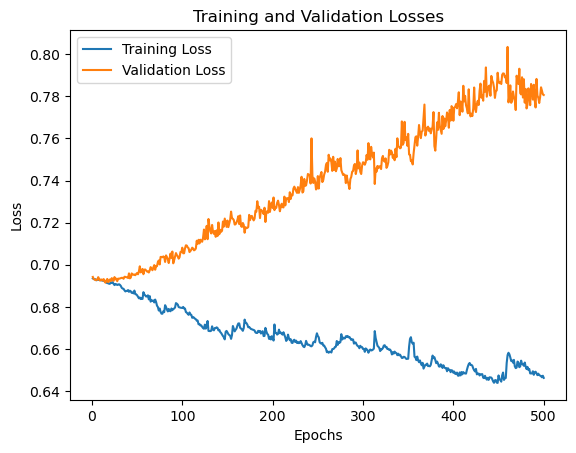

In [9]:
# train RNN model

start_time = time.time()

train_loss, validation_loss = LSTM_RNN.train_model(train_dataloader = train_dataloader,
                                                       validation_dataloader = validation_dataloader,
                                                       num_epochs = num_epochs,
                                                       loss_kind = loss_kind,
                                                       optimizer = optimizer)

# print train time
elapsed_time = ((time.time() - start_time) / 60)
print("Elapsed model training time:\n{:.2f} minutes".format(elapsed_time))

# plot loss curves

plt.figure()
plt.plot(range(1, num_epochs + 1), train_loss, label = 'Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

#### 6. Calculate and report the performance of your model on the training and test set. 15 points
- Calculate the accuracies on the training and test sets
- Print out the confusion matrix of model results on the test set: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html

In [10]:
# evaluate model

train_accuracy, y_train_hat, y_train = LSTM_RNN.evaluate(train_dataloader)
test_accuracy, y_test_hat, y_test = LSTM_RNN.evaluate(train_dataloader)

# print accuracies

print("Training accuracy:\n", train_accuracy)
print()
print("Test accuracy:\n", test_accuracy)
print()

# confusion matrices

print("Confusion matrix for train set:\n", confusion_matrix(y_train, y_train_hat))
print()
print("Confusion matrix for test set:\n", confusion_matrix(y_test, y_test_hat))
print()


Training accuracy:
 0.5738

Test accuracy:
 0.5718

Confusion matrix for train set:
 [[ 3912  8527]
 [ 2128 10433]]

Confusion matrix for test set:
 [[ 3866  8573]
 [ 2132 10429]]

